## Functions

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
from scipy.spatial import distance
from scipy.special import legendre
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from skimage import measure
import math
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
def get_video_from_csv(file_path, size = 32, colorMap = False):
    # Read the CSV file
    df = pd.read_csv(file_path)
    X = []
    y = df.iloc[0][0].split(';')[1].split('_')[3] # position label
    y = int(y)
    
    for i in range(7,len(df)):
        
        frame = df.iloc[i] # 8th line
        frame = frame.iloc[0].split(';')  # first column
        frame = frame[1:] # remove timestap
        frame = [float(frame[i]) for i in range(1024)]
        frame = np.array(frame)
        frame = frame.reshape(32, 32)                           
        frame = cv2.rotate(frame, cv2.ROTATE_180)
        frame = frame.reshape(size,size)
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        if colorMap :
            frame = cv2.applyColorMap(frame, cv2.COLORMAP_JET)
            
        if np.count_nonzero (frame ==0) < 1022 : # frame should at least have two non zero pixels
            X.append(frame)

    X = np.array(X)
    return X,y


def get_data_from_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    X = df.iloc[7] # 8th line
    X = X.iloc[0].split(';')  # first column
    X = X[1:]
    X = [float(X[i]) for i in range(1024)]
    X = np.array(X)
    X = X.reshape(32, 32)

    y = int(file_path.split('/')[1].split('_')[3])
#     y = int(y)
    
    ID = int(file_path.split('/')[1].split('_')[2])

    return X,y, ID




def four_quadrants_features(image, hip_leg_repartition=3/7, white_pixels_threshold = 100, Normalize = True):
    original_image = image.copy()

    kernel = np.ones((4, 4), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.dilate(image, kernel, iterations=1)

    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
        largest_contours = sorted_contours[:2]
        x_min, y_min, width, height = cv2.boundingRect(np.vstack(largest_contours))
        x_max, y_max = x_min + width, y_min + height

        divide_point_left = int(x_min + hip_leg_repartition * width)
        divide_point_upper = int(y_min + 0.5 * height)

        mask_upper_hip = np.zeros_like(original_image)
        mask_bottom_hip = np.zeros_like(original_image)
        mask_upper_leg = np.zeros_like(original_image)
        mask_bottom_leg = np.zeros_like(original_image)

        mask_upper_hip[y_min:divide_point_upper, x_min:divide_point_left] = 255
        mask_bottom_hip[divide_point_upper:y_max, x_min:divide_point_left] = 255
        mask_upper_leg[y_min:divide_point_upper, divide_point_left:x_max] = 255
        mask_bottom_leg[divide_point_upper:y_max, divide_point_left:x_max] = 255

        upper_hip = cv2.bitwise_and(original_image, original_image, mask=mask_upper_hip)
        bottom_hip = cv2.bitwise_and(original_image, original_image, mask=mask_bottom_hip)
        upper_leg = cv2.bitwise_and(original_image, original_image, mask=mask_upper_leg)
        bottom_leg = cv2.bitwise_and(original_image, original_image, mask=mask_bottom_leg)

        # center_of_mass_image = np.array(center_of_mass(original_image))
        # center_of_mass_upper_hip = np.array(center_of_mass(upper_hip))
        # center_of_mass_bottom_hip = np.array(center_of_mass(bottom_hip))
        # center_of_mass_upper_leg = np.array(center_of_mass(upper_leg))
        # center_of_mass_bottom_leg = np.array(center_of_mass(bottom_leg))
        
        # distances = [
        #     np.linalg.norm(center_of_mass_image - center_of_mass_upper_hip),
        #     np.linalg.norm(center_of_mass_image - center_of_mass_bottom_hip),
        #     np.linalg.norm(center_of_mass_image - center_of_mass_upper_leg),
        #     np.linalg.norm(center_of_mass_image - center_of_mass_bottom_leg)
        # ]
        # Centers of mass
        center_of_mass_image = np.array(center_of_mass(original_image))
        coms = [
            np.array(center_of_mass(upper_hip)),
            np.array(center_of_mass(bottom_hip)),
            np.array(center_of_mass(upper_leg)),
            np.array(center_of_mass(bottom_leg))
        ]
        
        distances = []
        angles = []
        for com in coms:
            vector = com - center_of_mass_image
            distance = np.linalg.norm(vector)
            angle = np.arctan2(vector[0], vector[1])  # Note: row (y) first for arctan2
            distances.append(distance)
            angles.append(angle)
        
        # Distance Normalization
        if Normalize : 
            width_height_norm = np.sqrt(width**2 + height**2)
            distances = [distance*100 / width_height_norm for distance in distances]

        total_white_pixels = np.sum(original_image[original_image > white_pixels_threshold])
        percentage_white_upper_hip = (np.sum(upper_hip[upper_hip > white_pixels_threshold]) / total_white_pixels) * 100
        percentage_white_bottom_hip = (np.sum(upper_hip[bottom_hip > white_pixels_threshold]) / total_white_pixels) * 100
        percentage_white_upper_leg = (np.sum(upper_hip[upper_leg > white_pixels_threshold]) / total_white_pixels) * 100
        percentage_white_bottom_leg = (np.sum(upper_hip[bottom_leg > white_pixels_threshold]) / total_white_pixels) * 100

        percentages = [
            percentage_white_upper_hip,
            percentage_white_bottom_hip,
            percentage_white_upper_leg,
            percentage_white_bottom_leg
        ]

        result = distances + angles
        return result
    else:
        raise ValueError("No contours found in the image.")


def image_props(image):
    moments = measure.moments(image)
    m00, m01, m10, m11, m20, m02 = moments[0, 0], moments[0, 1], moments[1, 0], moments[1, 1], moments[2, 0], moments[0, 2]
    
    x_c, y_c = m10 / m00, m01 / m00
    
    central_moments = measure.moments_central(image, center=(x_c, y_c))
    mu20, mu02, mu11 = central_moments[0, 2], central_moments[2, 0], central_moments[1, 1]

    orientation = 0.5 * math.atan2(2 * mu11, (mu20 - mu02))
    eccentricity = np.sqrt(1 - (mu02 + mu20 - np.sqrt((mu20 - mu02)**2 + 4 * mu11**2)) / (mu02 + mu20 + np.sqrt((mu20 - mu02)**2 + 4 * mu11**2)))
    
    # Eigen Values : major & minor axis length
    lambda_1 = (mu20 + mu02) / 2 + np.sqrt(4 * mu11**2 + (mu20 - mu02)**2) / 2
    lambda_2 = (mu20 + mu02) / 2 - np.sqrt(4 * mu11**2 + (mu20 - mu02)**2) / 2
    
    return np.array([y_c, x_c, orientation, eccentricity, lambda_1, lambda_2])

def image_central_moments(image, optimize = True):
    moments = measure.moments(image)
    x_bar = moments[1, 0] / moments[0, 0]
    y_bar = moments[0, 1] / moments[0, 0]
    central_moments = measure.moments_central(image, center=(x_bar, y_bar),order=2)
    central_moments = central_moments.flatten()
    if optimize :
        n = len(central_moments)
        points_to_drop = [1, 3]
        central_moments = [central_moments[i] for i in range(n) if i not in points_to_drop]
    return central_moments

def image_normalized_moments(image, optimize = True):
    mu = measure.moments_central(image)
    normalized_mu = measure.moments_normalized(mu, order=2)
    normalized_mu = normalized_mu[:3,:3].flatten()
    if optimize :
        n = len(normalized_mu)
        points_to_drop = [0, 1, 3, n-1]
        normalized_mu = [normalized_mu[i] for i in range(n) if i not in points_to_drop]
    
    return normalized_mu


def image_Hu_moments(image, optimize = True):
    mu = measure.moments_central(image)
    nu = measure.moments_normalized(mu)
    hu_moments = measure.moments_hu(nu)
    if optimize :
        # n = len(hu_moments)
        # points_to_drop = [2,3,4,5,6]
        hu_moments = hu_moments[0:2]
    return hu_moments

# source : FAST COMPUTATION OF LEGENDRE AND ZERNIKE MOMENTS - india 
legendre_polynomials = [legendre(p) for p in range(4)]

def legendre_moments(original_image, max_order=3, Normalize_coord = True):
    image = original_image.copy() 
    N = image.shape[0]  # Assuming the image is square
    moments = np.zeros((max_order + 1, max_order + 1))
    lambdas = moments
    
    # Compute Legendre moments
    for p in range(max_order + 1):
        for q in range(max_order + 1):
            moment = 0
            legendre_p = legendre_polynomials[p]
            legendre_q = legendre_polynomials[q]
            for i in range(N):
                for j in range(N):
                    if Normalize_coord :
                    # Coord normalization for general approches
                        xi = 2*i / (N - 1) - 1
                        xj = 2*j / (N - 1) - 1                  
                    else :
                        xi, xj = i, j
                    moment += legendre_p(i) * legendre_q(j) * image[j, i]
            lambda_pq = (2 * p + 1) * (2 * q + 1) / ((N - 1) ** 2)
            lambdas[p, q] = lambda_pq
            moments[p, q] = moment * lambda_pq
    return moments, lambdas

def image_LMI(image):
    """
    Based on 'Translation and scale invariants of Legedre Moments, Chee Way Chong [1]'
    """
    moments, lambdas = legendre_moments(image)
    phi = np.zeros((4, 4))
    L00, l00 = moments[0, 0], lambdas[0, 0]
    L10, l10 = moments[1, 0], lambdas[1, 0]
    L01, l01 = moments[0, 1], lambdas[0, 1]
    L20, l20 = moments[2, 0], lambdas[2, 0]
    L02, l02 = moments[0, 2], lambdas[0, 2]
    L11, l11 = moments[1, 1], lambdas[1, 1]
    L30, l30 = moments[3, 0], lambdas[3, 0]
    L03, l03 = moments[0, 3], lambdas[0, 3]
    L12, l12 = moments[1, 2], lambdas[1, 2]
    L21, l21 = moments[2, 1], lambdas[2, 1]
    
    # Centroids
    x0 = l00 * L10 /(l10 * L00)
    y0 = l00 * L01 /(l01 * L00)
    
    phi[1,0] = L10 - x0 * l10/l00 * L00
    phi[0,1] = L01 - y0 * l01/l00 * L00
    
    phi[2,0] = L20 - 3*x0 * l20/l10 * L10 + 3*x0**2/2 * l20/l00 * L00
    phi[0,2] = L02 - 3*y0 * L02/l01 * L01 + 3*y0**2/2 * l02/l00 * L00
    phi[1,1] = L11 - x0 * l11/l01 * L01 - y0 * l11/10* L10 + x0*y0 * l11/l00 * L00 
    
    phi[3,0] = L30 - 5*x0 * l30/l20 * L20 + 15*x0**2/2 * l30/l10 * L10 - (x0 + 5*x0**3/2) * l30/l00 * L00
    phi[0,3] = L03 - 5*y0 * l03/l02 * L02 + 15*y0**2/2 * l03/l01 * L10 - (y0 + 5*y0**3/2) * l03/l00 * L00
    phi[2,1] = L21 - y0 * l21/l20 * L20 - 3*x0*l21/l11 * L11 + 3*x0*y0* l21/l10 * L10 + 3*x0**2/2 * l21/l01 * L01 - 3*x0**2*y0/2* l21/l00 * L00
    phi[1,2] = L12 - x0 * l12/l01 * L02 - 3*y0*l12/l11 * L11 + 3*x0*y0* l12/l01 * L01 + 3*y0**2/2 * l12/l10 * L10 - 3*x0*y0**2/2* l12/l00 * L00  
    
    # return(np.array([phi[1,0], phi[0,1], phi[2,0], phi[0,2], phi[1,1], phi[3,0], phi[0,3], phi[2,1], phi[1,2]]))
    # return(np.array([phi[3,0], phi[0,3], phi[2,1]]))
    return(np.array([phi[2,0], phi[0,2], phi[1,1], phi[0,3], phi[1,2]]))

def Moment_2_parts(image, myfunction, hip_leg_repartition=3/7, white_pixels_threshold=100, Normalize=None):
    original_image = image.copy()

    kernel = np.ones((4, 4), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.dilate(image, kernel, iterations=1)

    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Only sort required contours
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
        x_min, y_min, width, height = cv2.boundingRect(np.vstack(sorted_contours))
        x_max, y_max = x_min + width, y_min + height

        divide_point = int(y_min + 0.5 * height)

        # Masks
        upper_mask = np.zeros_like(original_image)
        bottom_mask = np.zeros_like(original_image)
        upper_mask[y_min:divide_point, x_min:x_max] = 255
        bottom_mask[divide_point:y_max, x_min:x_max] = 255

        # Applied Masks
        upper_part = cv2.bitwise_and(original_image, original_image, mask=upper_mask)
        bottom_part = cv2.bitwise_and(original_image, original_image, mask=bottom_mask)

        # Apply function on each part
        result_up = myfunction(upper_part)
        result_bot = myfunction(bottom_part)
        result = np.concatenate((result_up, result_bot))

        return np.array(result)
    else:
        raise ValueError("No contours found in the image.")

# Importing data

In [3]:
data_directory = 'data/' # Alparsalan dataset : 5 labels
csv_files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]
X_Alp, Y_Alp, IDs = [], [], []
for file_name in csv_files:
    file_path = os.path.join(data_directory, file_name)
    x, y, ID = get_data_from_csv(file_path)
    x = cv2.rotate(x, cv2.ROTATE_180)
    x = cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    X_Alp.append(x)
    Y_Alp.append(y)
    IDs.append(ID)

X_Alp = np.array(X_Alp)
Y_Alp = np.array(Y_Alp)
IDS = np.array(IDs)


data_directory = 'vid_data/'
# cv2.namedWindow('Greyscale /jet colormap', cv2.WINDOW_NORMAL)
# List all the CSV files in the directory
csv_files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]
X, Y = [], []
for file_name in csv_files:
    # assembling data from each file
    file_path = os.path.join(data_directory, file_name)
    x, y = get_video_from_csv(file_path)
    X.append(x)
    Y.append(y)

min_length = min(video.shape[0] for video in X)

X = np.array([video[:min_length] for video in X])
X = X.astype('float32')  #turn data type to float32

Y = np.array(Y)
print(X.shape)
print(Y.shape)

C:\Users\imad_\AppData\Local\Temp\ipykernel_37348\487761540.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = df.iloc[0][0].split(';')[1].split('_')[3] # position label
C:\Users\imad_\AppData\Local\Temp\ipykernel_37348\487761540.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = df.iloc[0][0].split(';')[1].split('_')[3] # position label
C:\Users\imad_\AppData\Local\Temp\ipykernel_37348\487761540.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

(161, 76, 32, 32)
(161,)


In [4]:
# One sec one Frame + Feature Extraction
labels = []
frames = []
data_extended = []
for i in range(X.shape[0]) :
    for j in range(26, X.shape[1], 10) :
        frame = cv2.normalize(X[i, j], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        frames.append(frame)
        labels.append(Y[i])

Y_extended=np.array(labels)
frames = np.array(frames)

# using reduced DB
frames = cv2.normalize(X[:,-10], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

Y_extended = Y
print('DB shape :',frames.shape)
print('Labels shape :',Y.shape)



DB shape : (161, 32, 32)
Labels shape : (161,)


### Feature Extraction : Raw / Com-Edge distance / 4 Quadrants /  Imag Props

In [5]:
raw = frames.reshape(-1, 1024)

four_quadrants = np.array([four_quadrants_features(np.uint8(frame)) for frame in frames])
four_quadrants = np.nan_to_num(four_quadrants, nan=0)

image_prop = np.array([Moment_2_parts(np.uint8(image), image_props) for image in frames])
centered_moments = np.array([Moment_2_parts(np.uint8(image), image_central_moments) for image in frames])
normalized_moments = np.array([Moment_2_parts(np.uint8(image), image_normalized_moments) for image in frames])
Hu_moments = np.array([Moment_2_parts(np.uint8(image), image_Hu_moments) for image in frames])
# LMI = np.array([Moment_2_parts(np.uint8(image), image_LMI) for image in frames])





print('raw shape : ',raw.shape)
print('normalized_moments shape : ', normalized_moments.shape)
print('4 quadrants shape : ', four_quadrants.shape)
print('image_props shape : ', image_prop.shape)
print('Hu_moments shape : ', Hu_moments.shape)
# print('LMI shape : ', LMI.shape)

raw_Alp = X_Alp.reshape(-1, 1024)

four_quadrants_Alp = np.array([four_quadrants_features(np.uint8(frame)) for frame in X_Alp])
four_quadrants_Alp = np.nan_to_num(four_quadrants_Alp, nan=0)

image_prop_Alp = np.array([Moment_2_parts(np.uint8(image), image_props) for image in X_Alp])
centered_moments_Alp = np.array([Moment_2_parts(np.uint8(image), image_central_moments) for image in X_Alp])
normalized_moments_Alp = np.array([Moment_2_parts(image, image_normalized_moments) for image in X_Alp])
Hu_moments_Alp = np.array([Moment_2_parts(image, image_Hu_moments) for image in X_Alp])
# LMI_Alp = np.array([Moment_2_parts(image, image_LMI) for image in X_Alp])

print("Alparslan's :\n")
print('raw shape : ',raw_Alp.shape)
print('normalized_moments shape : ', normalized_moments_Alp.shape)
print('4 quadrants shape : ', four_quadrants_Alp.shape)
print('image_props shape : ', image_prop_Alp.shape)
print('Hu_moments shape : ', Hu_moments_Alp.shape)
# print('LMI shape : ', LMI_Alp.shape)

C:\Users\imad_\AppData\Roaming\Python\Python312\site-packages\scipy\ndimage\_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


raw shape :  (161, 1024)
normalized_moments shape :  (161, 10)
4 quadrants shape :  (161, 8)
image_props shape :  (161, 12)
Hu_moments shape :  (161, 4)
Alparslan's :

raw shape :  (150, 1024)
normalized_moments shape :  (150, 10)
4 quadrants shape :  (150, 8)
image_props shape :  (150, 12)
Hu_moments shape :  (150, 4)


In [6]:
features = [raw, four_quadrants, image_prop, centered_moments, normalized_moments, Hu_moments]
features_Alp = [raw_Alp, four_quadrants_Alp, image_prop_Alp, centered_moments_Alp, normalized_moments_Alp, Hu_moments_Alp]

features_name = ['raw','4 quadrants', 'Image props', 'Central Moments', 'normalized Moments', 'Hu Moments']

# Normalizing each feature with its corresponding from Dataset 2

for i in range(len(features)):
    if i == 1 : continue
    scaler = StandardScaler()
    features[i] = scaler.fit_transform(features[i])
    features_Alp[i] = scaler.fit_transform(features_Alp[i])

# combined_features = np.hstack(features)
# combined_features_ALP = np.hstack(features)

### Training

In [7]:
from sklearn.preprocessing import StandardScaler

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
models = {
    'SVM': SVC(kernel='linear'),
    'Knn': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=18)
}

results = []
pbar = tqdm(total=len(features) * len(models), desc="Progress", position=0, leave=True)

for feature_array_name, feature_array in zip(features_name, features):
    for model_name, model in models.items():
        try :
        #     if model_name == 'SVM' and feature_array_name in ['Image props', 'Central Moments']:
        #         features_ = scaler.fit_transform(feature_array.copy())
        #         cv_scores = cross_val_score(model, features_, Y, cv=cv, scoring='accuracy')
        #     else :
        #         # Perform cross-validation
            cv_scores = cross_val_score(model, feature_array, Y, cv=cv, scoring='accuracy')
        except :
            print(model_name,feature_array_name)
            continue
        # Store results in a dictionary
        result_dict = {
            'Feature Array': feature_array_name,
            'Array Shape': feature_array.shape,
            'Model': model_name,
            'Max Score (%)': max(cv_scores.round(4))*100,
            'Mean Accuracy (%)': cv_scores.mean()*100,
            'Standard Deviation (%)': cv_scores.std()*100
        }
        
        # Append the dictionary to the results list
        results.append(result_dict)
        pbar.update(1)
        
# Close the progress bar
pbar.close()
# Convert the results list into a DataFrame
One_feature_df = pd.DataFrame(results)
# One_feature_df[['Mean Accuracy (%)', 'Standard Deviation (%)']] = results_df[['Mean Accuracy (%)', 'Standard Deviation (%)']].round(2)

def highlight_max(s):
    if s.name == max_accuracy_index:
        return ['background-color: yellow'] * len(s)
    else:
        return [''] * len(s)
max_accuracy_index = One_feature_df['Mean Accuracy (%)'].idxmax()
One_feature_df_ = One_feature_df.style.apply(highlight_max, axis=1)
display(One_feature_df_)

Progress:   0%|                                                                                 | 0/18 [00:00<?, ?it/s]C:\Users\imad_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\imad_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, 

,Feature Array,Array Shape,Model,Max Score (%),Mean Accuracy (%),Standard Deviation (%)
0,raw,"(161, 1024)",SVM,90.620000,85.151515,5.095859
1,raw,"(161, 1024)",Knn,90.620000,83.901515,5.844575
2,raw,"(161, 1024)",Random Forest,90.620000,85.151515,5.095859
3,4 quadrants,"(161, 8)",SVM,75.000000,68.920455,6.644570
4,4 quadrants,"(161, 8)",Knn,90.620000,76.420455,8.208212
5,4 quadrants,"(161, 8)",Random Forest,93.750000,81.401515,9.790513
6,Image props,"(161, 12)",SVM,87.500000,74.545455,7.183850
7,Image props,"(161, 12)",Knn,87.500000,83.863636,2.225359
8,Image props,"(161, 12)",Random Forest,87.500000,82.613636,2.453072
9,Central Moments,"(161, 14)",SVM,81.250000,70.246212,6.650506


#### Train on 1 test on 2 

In [8]:
results = []
pbar = tqdm(total=len(features_Alp) * len(models), desc="Progress", position=0, leave=True)

for feature_array_name, feature_array, feature_array_Alp in zip(features_name, features, features_Alp):
    for model_name, model in models.items():
        try :
            # if model_name == 'SVM' and feature_array_name in ['Image props', 'Central Moments']:
            #     features_ = scaler.fit_transform(feature_array)
            #     feature_Alp = scaler.transorm(feature_array_Alp)
            #     model.fit(features_, Y)
            #     y_pred = model.predict(feature_Alp)
            # else :
            #     # Perform cross-validation
            model.fit(feature_array, Y)
            y_pred = model.predict(feature_array_Alp)
        except :
            print(model_name,feature_array_name)
            continue
        
        result_dict = {
            'Feature Array': feature_array_name,
            'Array Shape': feature_array.shape,
            'Model': model_name,
            'Accuracy (%)': accuracy_score(Y_Alp, y_pred)*100,
        }
        
        # Append the dictionary to the results list
        results.append(result_dict)
        pbar.update(1)
        
# Close the progress bar
pbar.close()

# Convert the results list into a DataFrame
fit_test_df = pd.DataFrame(results)
# results_df[['Mean Accuracy (%)', 'Standard Deviation (%)']] = results_df[['Mean Accuracy (%)', 'Standard Deviation (%)']].round(2)

max_accuracy_index = fit_test_df['Accuracy (%)'].idxmax()
fit_test_df_ = fit_test_df.style.apply(highlight_max, axis=1)
display(fit_test_df_)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 19.58it/s]


,Feature Array,Array Shape,Model,Accuracy (%)
0,raw,"(161, 1024)",SVM,36.666667
1,raw,"(161, 1024)",Knn,44.666667
2,raw,"(161, 1024)",Random Forest,36.666667
3,4 quadrants,"(161, 8)",SVM,46.666667
4,4 quadrants,"(161, 8)",Knn,51.333333
5,4 quadrants,"(161, 8)",Random Forest,48.666667
6,Image props,"(161, 12)",SVM,50.666667
7,Image props,"(161, 12)",Knn,44.666667
8,Image props,"(161, 12)",Random Forest,44.000000
9,Central Moments,"(161, 14)",SVM,51.333333


In [9]:
feature_array_name == 'Image props'

False

### Features combinaison : 2 out of 4

In [10]:
from itertools import combinations


# Generate combinations of two features
feature_combinations = list(combinations(zip(features_name[1:], features[1:]), 2))

results = []
pbar = tqdm(total=len(feature_combinations) * len(models), desc="Progress", position=0, leave=True)

for (feature1_name, feature1), (feature2_name, feature2) in feature_combinations:
    for model_name, model in models.items():
        # Combine the two features
        combined_features = np.concatenate((feature1, feature2), axis=1)
        try :
            cv_scores = cross_val_score(model, combined_features, Y, cv=cv, scoring='accuracy')
        except :
            print(model_name,feature_array_name)
            continue
        
        
        # Store results in a dictionary
        result_dict = {
            'Feature Combination': f'{feature1_name} x {feature2_name}',
            'Array Shapes': f'{combined_features.shape}',
            'Model': model_name,
            'Max Score (%)': max(cv_scores.round(4))*100,
            'Mean Accuracy (%)': cv_scores.mean()*100,
            'Standard Deviation (%)': cv_scores.std()*100
        }
        
        # Append the dictionary to the results list
        results.append(result_dict)
        pbar.update(1)
        
# Close the progress bar
pbar.close()

# Convert the results list into a DataFrame
Two_features_df = pd.DataFrame(results)
# results_df[['Mean Accuracy (%)', 'Standard Deviation (%)']] = results_df[['Mean Accuracy (%)', 'Standard Deviation (%)']].round(2)

max_accuracy_index = Two_features_df['Mean Accuracy (%)'].idxmax()
Two_features_df_ = Two_features_df.style.apply(highlight_max, axis=1)
display(Two_features_df_)


Progress: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.89it/s]


,Feature Combination,Array Shapes,Model,Max Score (%),Mean Accuracy (%),Standard Deviation (%)
0,4 quadrants x Image props,"(161, 20)",SVM,78.120000,72.045455,3.440199
1,4 quadrants x Image props,"(161, 20)",Knn,93.750000,85.132576,4.821555
2,4 quadrants x Image props,"(161, 20)",Random Forest,93.750000,86.382576,4.867977
3,4 quadrants x Central Moments,"(161, 22)",SVM,81.250000,77.045455,2.927102
4,4 quadrants x Central Moments,"(161, 22)",Knn,93.750000,83.276515,6.553030
5,4 quadrants x Central Moments,"(161, 22)",Random Forest,87.500000,82.007576,4.906729
6,4 quadrants x normalized Moments,"(161, 18)",SVM,81.250000,73.276515,6.177379
7,4 quadrants x normalized Moments,"(161, 18)",Knn,90.620000,78.295455,9.371728
8,4 quadrants x normalized Moments,"(161, 18)",Random Forest,90.620000,85.719697,3.155214
9,4 quadrants x Hu Moments,"(161, 12)",SVM,78.120000,70.776515,7.115921


In [11]:
feature_combinations = list(combinations(zip(features_name[1:], features[1:], features_Alp[1:]), 2))
results = []
pbar = tqdm(total=len(feature_combinations) * len(models), desc="Progress", position=0, leave=True)

for (feature1_name, feature1, feature_Alp_1), (feature2_name, feature2, feature_Alp_2) in feature_combinations:
    for model_name, model in models.items():
        
        combined_features = np.concatenate((feature1, feature2), axis=1)
        combined_features_Alp = np.concatenate((feature_Alp_1, feature_Alp_2), axis=1)
              
        try :
            # Perform cross-validation
            model.fit(combined_features, Y)
            y_pred = model.predict(combined_features_Alp)
        except :
            print(model_name,feature_array_name)
            continue
        
        result_dict = {
            'Feature Combination': f'{feature1_name} x {feature2_name}',
            'Array Shapes': f'{combined_features.shape}',
            'Model': model_name,
            'Accuracy (%)': accuracy_score(Y_Alp, y_pred)*100,
        }
        
        # Append the dictionary to the results list
        results.append(result_dict)
        pbar.update(1)
        
# Close the progress bar
pbar.close()

# Convert the results list into a DataFrame
Two_fit_test_df = pd.DataFrame(results)
# results_df[['Mean Accuracy (%)', 'Standard Deviation (%)']] = results_df[['Mean Accuracy (%)', 'Standard Deviation (%)']].round(2)

max_accuracy_index = Two_fit_test_df['Accuracy (%)'].idxmax()
Two_fit_test_df_ = Two_fit_test_df.style.apply(highlight_max, axis=1)
display(Two_fit_test_df_)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.32it/s]


,Feature Combination,Array Shapes,Model,Accuracy (%)
0,4 quadrants x Image props,"(161, 20)",SVM,52.666667
1,4 quadrants x Image props,"(161, 20)",Knn,54.666667
2,4 quadrants x Image props,"(161, 20)",Random Forest,54.000000
3,4 quadrants x Central Moments,"(161, 22)",SVM,63.333333
4,4 quadrants x Central Moments,"(161, 22)",Knn,52.000000
5,4 quadrants x Central Moments,"(161, 22)",Random Forest,48.666667
6,4 quadrants x normalized Moments,"(161, 18)",SVM,54.000000
7,4 quadrants x normalized Moments,"(161, 18)",Knn,52.666667
8,4 quadrants x normalized Moments,"(161, 18)",Random Forest,54.666667
9,4 quadrants x Hu Moments,"(161, 12)",SVM,50.666667


### Confusion Matrix for Best combination for each model

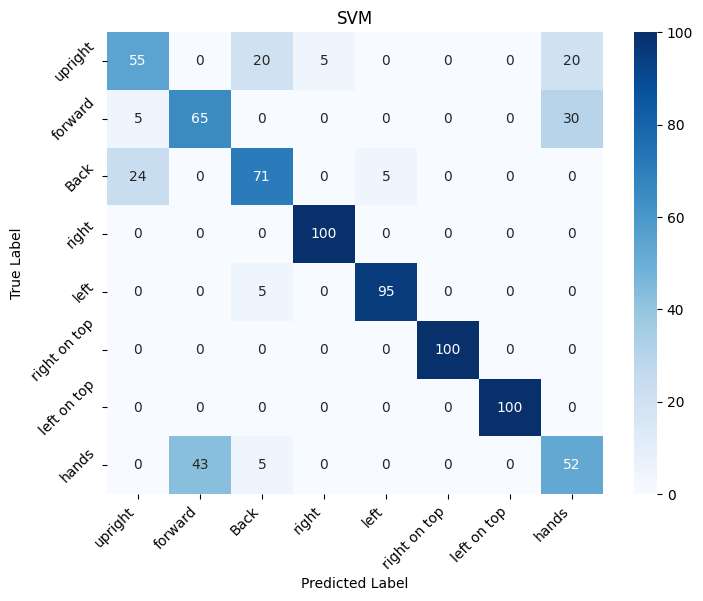

In [12]:
class_name = ["upright", "forward", "Back", "right", "left", "right on top", "left on top", "hands"]
# models = {
#     'SVM': SVC(kernel='linear'),
#     'Knn': KNeighborsClassifier(n_neighbors=3),
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=18)
# }
# SVM model
# features = [raw, four_quadrants, image_prop, centered_moments, normalized_moments, Hu_moments]
# features_Alp = [raw_Alp, four_quadrants_Alp, image_prop_Alp, centered_moments_Alp, normalized_moments_Alp, Hu_moments_Alp]

# features_name = ['raw','4 quadrants', 'Image props', 'Central Moments', 'normalized Moments', 'Hu Moments']
features_comb = np.concatenate((features[2], features[3]), axis=1)
svm_model = SVC(kernel='linear')

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# Collect all predictions and true labels
all_y_true = []
all_y_pred = []

for train_idx, test_idx in cv.split(features_comb, Y):
    X_train, X_test = features_comb[train_idx], features_comb[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
accuracy = accuracy_score(all_y_true, all_y_pred)

# Normalize by row (true class) to get percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".0f", cmap='Blues',
            xticklabels=class_name, yticklabels=class_name)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# plt.title("Confusion Matrix (Percentages), Acc = " + str(round(accuracy, 3)))
plt.title("SVM")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.savefig("SVM_CM.png", dpi=300, bbox_inches='tight')
plt.show()

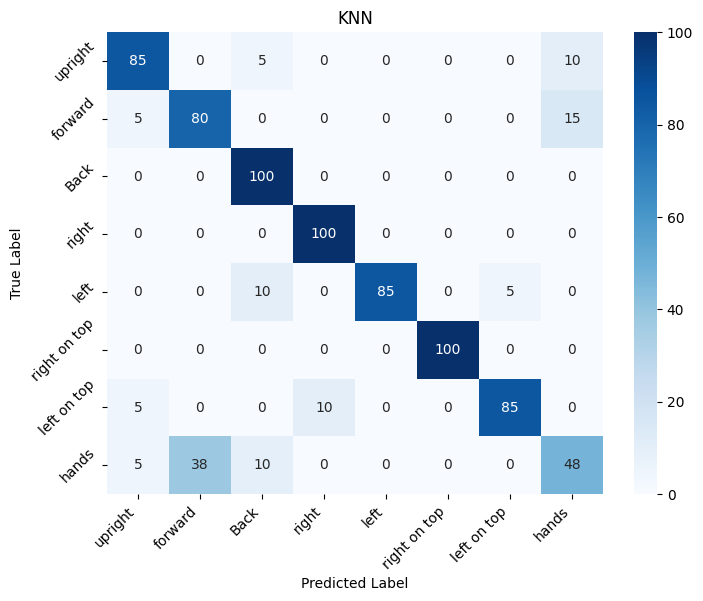

In [13]:
features_comb = np.concatenate((features[1], features[2]), axis=1)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# Collect all predictions and true labels
all_y_true = []
all_y_pred = []

for train_idx, test_idx in cv.split(features_comb, Y):
    X_train, X_test = features_comb[train_idx], features_comb[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
accuracy = accuracy_score(all_y_true, all_y_pred)

# Normalize by row (true class) to get percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".0f", cmap='Blues',
            xticklabels=class_name, yticklabels=class_name)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# plt.title("Confusion Matrix (Percentages), Acc = " + str(round(accuracy, 3)))
plt.title("KNN")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.savefig("KNN_CM.png", dpi=300, bbox_inches='tight')
plt.show()

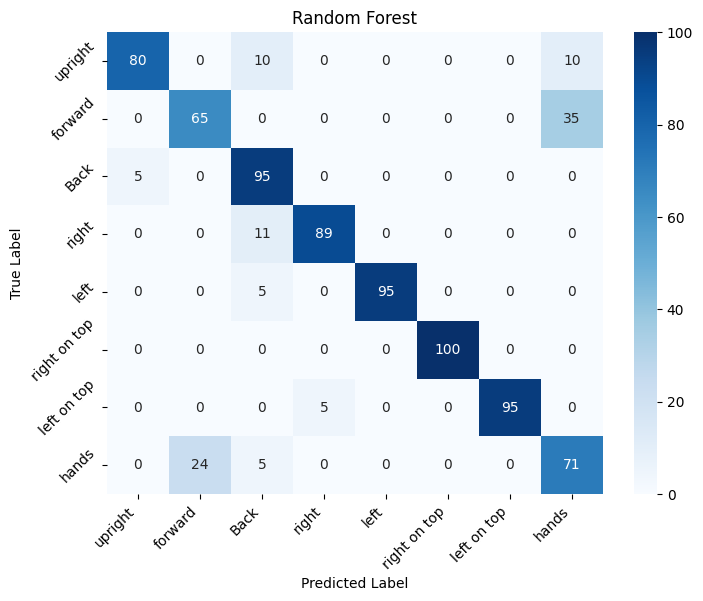

In [14]:
class_name = ["upright", "forward", "Back", "right", "left", "right on top", "left on top", "hands"]
features_comb = np.concatenate((features[1], features[2]), axis=1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=18)

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# Collect all predictions and true labels
all_y_true = []
all_y_pred = []

for train_idx, test_idx in cv.split(features_comb, Y):
    X_train, X_test = features_comb[train_idx], features_comb[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
accuracy = accuracy_score(all_y_true, all_y_pred)

# Normalize by row (true class) to get percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".0f", cmap='Blues',
            xticklabels=class_name, yticklabels=class_name)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# plt.title("Confusion Matrix (Percentages), Acc = " + str(round(accuracy, 3)))
plt.title("Random Forest")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.savefig("RF_CM.png", dpi=300, bbox_inches='tight')
plt.show()